## Facial keypoints detection

In this task you will create facial keypoint detector based on CNN regressor.


![title](example.png)

### Load and preprocess data

Script `get_data.py` unpacks data — images and labelled points. 6000 images are located in `images` folder and keypoint coordinates are in `gt.csv` file. Run the cell below to unpack data.

In [67]:
#from get_data import unpack
#unpack('facial-keypoints-data.zip')
#already unzipped
pd.__version__

'1.0.1'

In [1]:
!pip install opencv-python

Now you have to read `gt.csv` file and images from `images` dir. File `gt.csv` contains header and ground truth points for every image in `images` folder. It has 29 columns. First column is a filename and next 28 columns are `x` and `y` coordinates for 14 facepoints. We will make following preprocessing:
1. Scale all images to resolution $100 \times 100$ pixels.
2. Scale all coordinates to range $[-0.5; 0.5]$. To obtain that, divide all x's by width (or number of columns) of image, and divide all y's by height (or number of rows) of image and subtract 0.5 from all values.

Function `load_imgs_and_keypoint` should return a tuple of two numpy arrays: `imgs` of shape `(N, 100, 100, 3)`, where `N` is the number of images and `points` of shape `(N, 28)`.

In [2]:
### Useful routines for preparing data
from numpy import array, zeros
from os.path import join
from skimage.color import gray2rgb
from skimage.io import imread
from skimage.transform import resize
import skimage
import csv
import os
import cv2
import numpy as np
import pandas as pd



def load_imgs_and_keypoints(dirname='facial-keypoints'):
    df = pd.read_csv("data/gt.csv")
    all_rows = list(df.iterrows())
    imgs, points = [], []
    for index, row in all_rows:
        img = imread("data/images/"+row["filename"])
        img = gray2rgb(img)
        [old_height, old_width] = img.shape[0], img.shape[1]
        img = resize(img, (100, 100), anti_aliasing=True)
        [height, width] = img.shape[0], img.shape[1]
        point = row.values[1:]
        for i in range(0,len(point),2):
            point[i] = (point[i]/old_width)-0.5
            point[i+1] = (point[i+1]/old_height)-0.5
        imgs.append(img)
        points.append(point)
    return imgs, points
imgs, points = load_imgs_and_keypoints()

[-0.2765957446808511 -0.2872340425531915 -0.11702127659574468
 -0.30851063829787234 0.1063829787234043 -0.2978723404255319
 0.35106382978723405 -0.23404255319148937 -0.25531914893617025
 -0.21276595744680848 -0.1382978723404255 -0.22340425531914893
 -0.07446808510638298 -0.2021276595744681 0.12765957446808507
 -0.18085106382978722 0.22340425531914898 -0.18085106382978722
 0.32978723404255317 -0.14893617021276595 -0.04255319148936171
 -0.010638297872340441 -0.17021276595744683 0.14893617021276595
 -0.021276595744680826 0.2021276595744681 0.13829787234042556
 0.19148936170212771]


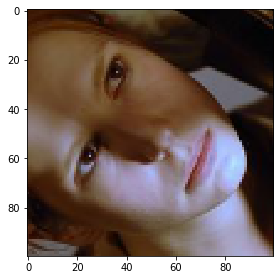

In [3]:
# Example of output
%matplotlib inline
from skimage.io import imshow
imshow(imgs[2])
print(points[1])

### Visualize data

Let's prepare a function to visualize points on image. Such function obtains two arguments: an image and a vector of points' coordinates and draws points on image (just like first image in this notebook).

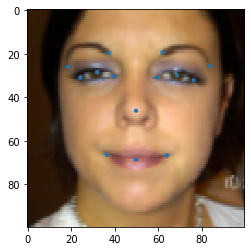

In [74]:
import matplotlib.pyplot as plt
# Circle may be useful for drawing points on face
# See matplotlib documentation for more info
from matplotlib.patches import Circle

def visualize_points(img, points):
    # Write here function which obtains image and normalized
    fig,ax = plt.subplots(1)
    ax.set_aspect('equal')
    ax.imshow(img)
    for i in range(0,len(points),2):
        x, y = (points[i]+0.5)*img.shape[0], (points[i+1]+0.5)*img.shape[1]
        circ = Circle((x,y),1)
        ax.add_patch(circ)
    plt.show()
visualize_points(imgs[100], points[100])

### Train/val split

Run the following code to obtain train/validation split for training neural network.

In [72]:
from sklearn.model_selection import train_test_split
imgs_train, imgs_val, points_train, points_val = train_test_split(imgs, points, test_size=0.1)

### Simple data augmentation

For better training we will use simple data augmentation — flipping an image and points. Implement function flip_img which flips an image and its' points. Make sure that points are flipped correctly! For instance, points on right eye now should be points on left eye (i.e. you have to mirror coordinates and swap corresponding points on the left and right sides of the face). VIsualize an example of original and flipped image.

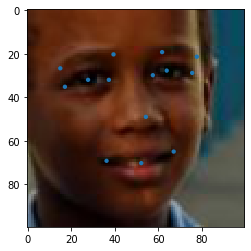

In [75]:
def flip_img(img, points):
    # Write your code for flipping here
    img = np.fliplr(img)
    for i in range(0, len(points), 2):
        points[i] = -points[i]
    return img, points

f_img, f_points = flip_img(imgs[1], points[1])
visualize_points(f_img, f_points)

Time to augment our training sample. Apply flip to every image in training sample. As a result you should obtain two arrays: `aug_imgs_train` and `aug_points_train` which contain original images and points along with flipped ones.

In [77]:
# Write your code here
aug_imgs_train = []
aug_points_train = []
for i in range(len(imgs_train)):
    img, point = flip_img(imgs_train[i], points_train[i])
    aug_imgs_train.append(imgs_train[i])
    aug_points_train.append(points_train[i])
    aug_imgs_train.append(img)
    aug_points_train.append(point)

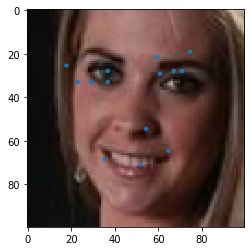

In [78]:
visualize_points(aug_imgs_train[2], aug_points_train[2])

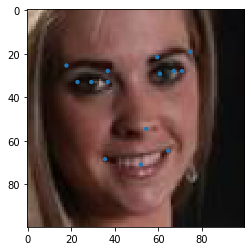

In [79]:
visualize_points(aug_imgs_train[3], aug_points_train[3])

### Network architecture and training

Now let's define neural network regressor. It will have 28 outputs, 2 numbers per point. The precise architecture is up to you. We recommend to add 2-3 (`Conv2D` + `MaxPooling2D`) pairs, then `Flatten` and 2-3 `Dense` layers. Don't forget about ReLU activations. We also recommend to add `Dropout` to every `Dense` layer (with p from 0.2 to 0.5) to prevent overfitting.


In [81]:
!pip install keras

In [82]:
import tensorflow as tf
from keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten,
    Dense, Dropout, Input
)
image_input = Input(shape=(100, 100, 3), name='input_layer')
conv_1 = Conv2D(8,
                kernel_size=(3, 3),
                padding='valid',
                activation='relu')(image_input)
conv_2 = Conv2D(8,
                kernel_size=(3, 3),
                padding='valid',
                activation='relu')(conv_1)
pool_1 = MaxPooling2D()(conv_1)
conv_3 = Conv2D(16,
                kernel_size=(3, 3),
                padding='valid',
                activation='relu')(pool_1)
conv_4 = Conv2D(16,
                kernel_size=(3, 3),
                padding='valid',
                activation='relu')(conv_3)
pool_2 = MaxPooling2D()(conv_4)
conv_5 = Conv2D(32,
                kernel_size=(3, 3),
                padding='valid',
                activation='relu')(pool_2)
conv_6 = Conv2D(32,
                kernel_size=(3, 3),
                padding='valid',
                activation='relu')(conv_5)

# Flatten the output of the convolutional layers
conv_flat = Flatten()(conv_6)

# Some dense layers with two separate outputs
fc_1 = Dense(128, activation='relu')(conv_flat)
fc_1 = Dropout(0.3)(fc_1)
fc_2 = Dense(64, activation='relu')(fc_1)
fc_2 = Dropout(0.3)(fc_2)
output = Dense(28, name='keypoints')(fc_2)
model = tf.keras.Model(inputs=image_input, outputs=output)
# Define here your model

Using TensorFlow backend.


In [83]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 98, 98, 8)         224       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 47, 47, 16)        1168      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 45, 45, 16)        2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 22, 22, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 20, 20, 32)        4640  

Time to train! Since we are training a regressor, make sure that you use mean squared error (mse) as loss. Feel free to experiment with optimization method (SGD, Adam, etc.) and its' parameters.

In [88]:
type(aug_imgs_train)

list

In [104]:
# ModelCheckpoint can be used for saving model during training.
# Saved models are useful for finetuning your model 
# See keras documentation for more info
from keras.callbacks import ModelCheckpoint
from keras.optimizers import SGD, Adam

model.compile(optimizer='adam', 
              loss='mse',
              metrics=['mse', 'mae'])
model.fit(tf.convert_to_tensor(aug_imgs_train), tf.convert_to_tensor(aug_points_train), epochs=100)
# Choose optimizer, compile model and run training

Train on 10800 samples
Epoch 1/100
10800/10800 [==============================] - 144s 13ms/sample - loss: 0.0014 - mse: 0.0014 - mae: 0.0263
Epoch 2/100
10800/10800 [==============================] - 131s 12ms/sample - loss: 0.0014 - mse: 0.0014 - mae: 0.0263
Epoch 3/100
10800/10800 [==============================] - 126s 12ms/sample - loss: 0.0014 - mse: 0.0014 - mae: 0.0261
Epoch 4/100
10800/10800 [==============================] - 127s 12ms/sample - loss: 0.0014 - mse: 0.0014 - mae: 0.0261
Epoch 5/100
10800/10800 [==============================] - 138s 13ms/sample - loss: 0.0014 - mse: 0.0014 - mae: 0.0260
Epoch 6/100
10800/10800 [==============================] - 136s 13ms/sample - loss: 0.0013 - mse: 0.0013 - mae: 0.0259
Epoch 7/100
10800/10800 [==============================] - 37238s 3s/sample - loss: 0.0013 - mse: 0.0013 - mae: 0.0257
Epoch 8/100
10800/10800 [==============================] - 116s 11ms/sample - loss: 0.0013 - mse: 0.0013 - mae: 0.0255
Epoch 9/100
10800/10800 [

### Visualize results

Now visualize neural network results on several images from validation sample. Make sure that your network outputs different points for images (i.e. it doesn't output some constant).

[[ 0.29696172 -0.27107972  0.11067143 -0.28760424 -0.08673413 -0.29124203
  -0.2731977  -0.29195628  0.24878559 -0.18079503  0.17635353 -0.18739787
   0.11186206 -0.18565752 -0.10601109 -0.18821569 -0.17545891 -0.19717655
  -0.24207908 -0.19481228 -0.00034775  0.02335977  0.11935282  0.21722293
  -0.01056448  0.2122751  -0.13437055  0.20808701]]


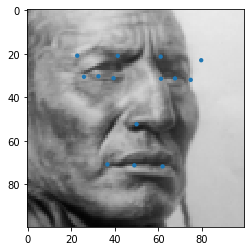

In [105]:
# Example of output
ind = 10
def check_test_image(ind):
    points_val = model.predict(np.array([imgs_val[ind]]))
    print(points_val)
    visualize_points(imgs_val[ind], points_val[0])
check_test_image(0)


[[ 0.27249148 -0.2845754   0.11515458 -0.28217408 -0.07184359 -0.28527233
  -0.2822648  -0.28423905  0.22999063 -0.19609237  0.16530421 -0.19805792
   0.10535593 -0.1940533  -0.10241608 -0.19214728 -0.17375073 -0.19842376
  -0.24633317 -0.19596687  0.05450338  0.03213992  0.13302456  0.19535907
   0.01960055  0.20546688 -0.12557203  0.19676921]]


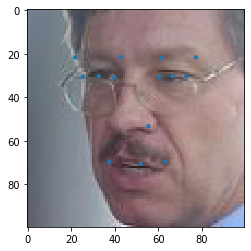

In [107]:
check_test_image(200)